# Homework 5 - Taming text

## Introduction

In this homework, a large corpus of emails released in public during the Hillary Clinton email controversy will be explored. The corpus is stored in `Data` directory. More informtion of the schema is available [here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

In [1]:
from os import path
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import nltk
import string
import re
import pycountry
from functools import partial
from cleaning import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

## 1. Word clouds
Generate two word clouds:
* One based on the raw corpus
* One based on the corpus pre-processed using the standard text pipeline. 

### a. __Raw text__

The data we are going to use for producing the clouds is taken from the file `Emails.csv` and refers to the column `MetadataSubject, ExtractedSubject, Extractedbody`. Hence, before proceeding to build up a unique cloud, we sould concatenate all the body and subject of the emails. In particular, we do the following:
* Import the data related to the Emails.

In [2]:
# Read data
emails = pd.read_csv('Data/Emails.csv', sep = ',')
emails.sample(3)

Id  DocNumber                               MetadataSubject  \
3083  3084  C05764991  UNITED STATES INSTITUTE OF PEACE: BACKGROUND   
4797  4798  C05768900                                  MTG. W/REYES   
991    992  C05760199                                         FOR S   

                MetadataTo       MetadataFrom  SenderPersonId  \
3083                   NaN                NaN             NaN   
4797                     H  Sullivan, Jacob J            87.0   
991   slaughtera@state.gov                  H            80.0   

               MetadataDateSent       MetadataDateReleased  \
3083                        NaN  2015-07-31T04:00:00+00:00   
4797  2010-03-25T04:00:00+00:00  2015-08-31T04:00:00+00:00   
991   2009-10-10T04:00:00+00:00  2015-07-31T04:00:00+00:00   

                                        MetadataPdfLink MetadataCaseNumber  \
3083  DOCUMENTS/HRCEmail_JulyWeb/Web_040_042_043/DOC...       F-2014-20439   
4797  DOCUMENTS/HRCEmail_August_Web/IPS-0071/DOC_0C0...       F-2014-20439   
991   DOCUMENTS/HRCEmail_JulyWeb/Web_1-11M/DOC_0C057...       F-2014-20439   

                            ...                          \
3083                        ...                           
4797                        ...                           
991                         ...                           

                 ExtractedTo                             ExtractedFrom  \
3083                     NaN                                       NaN   
4797                     NaN  Sullivan, Jacob J <SullivanJJ@state.gov>   
991   'slaughtera@state.gov'               H <hrod17@clintonemail.com>   

                                            ExtractedCc  \
3083                                                NaN   
4797  Valenzuela, Arturo A; Verma, Richard R; Johnso...   
991                                                 NaN   

                       ExtractedDateSent ExtractedCaseNumber  \
3083                                 NaN        F-2014-20439   
4797    Thursday, March 25, 2010 6:05 PM        F-2014-20439   
991   Saturday, October 10, 2009 6:06 AM        F-2014-20439   

     ExtractedDocNumber ExtractedDateReleased ExtractedReleaseInPartOrFull  \
3083          C05764991            07/31/2015              RELEASE IN FULL   
4797          C05768900            08/31/2015              RELEASE IN PART   
991           C05760199            07/31/2015              RELEASE IN PART   

                                      ExtractedBodyText  \
3083                                                NaN   
4797                                               FYI.   
991   We have tried before w/out success. Do you wan...   

                                                RawText  
3083  UNCLASSIFIED U.S. Department of State Case No....  
4797  UNCLASSIFIED U.S. Department of State Case No....  
991   UNCLASSIFIED U.S. Department of State Case No....  

[3 rows x 22 columns]

Due to the presence of missing data for the variable related to the `Subject`:
* Get the indeces of the email without `MetadataSubject`

In [3]:
index_null = emails[emails['MetadataSubject'].isnull()].index

* Get the indeces of the email without `ExtractedSubject`

In [4]:
index_null_extracted = emails[emails['ExtractedSubject'].isnull()].index

Then, compute the intersection to see which are the emails that merging the information contained in the two columns will remain unknown.

In [5]:
# Number that should remain null
print ("Number of email we do not know the subject: ", len(set(index_null).intersection(set(index_null_extracted))))

Number of email we do not know the subject:  250


We prefer using the `MetadataSubject` since it appears more cleaned, we use the information in `ExtractedSubject` though. Here we replace the null values of the former with those of the latter, whether it has it.

In [6]:
# For each mail without the subject
for i in index_null:
    emails.loc[i,'MetadataSubject'] = emails.loc[i, 'ExtractedSubject']

The entries that remain nulls even after these operation are filled in with the expression `No title`. The same is done for the bodies of the emails substituting the empty fields with the expression `No body text`.

In [7]:
# Get the subject - replacing nans
emails['MetadataSubject'].fillna('No title', inplace = True)

In [8]:
# Get bodies - replace nans
emails['ExtractedBodyText'].fillna('No body text', inplace = True)

* Extract the column relates to the corpus.

In [9]:
# Useful data
email_corpus = emails[['MetadataSubject', 'ExtractedBodyText']]

* Create a *unique* corpus.

We choose the columns of the data that provide some useful information - merged columns for subject of the email and also body text.

In [10]:
# Create a unique string from the list of entries for the subject feature
unique_corpus_1 = ' '.join([email_corpus['MetadataSubject'][i] for i in range(len(email_corpus))])

# Create a unique string from the list of entries for the body feature
unique_corpus_2 = ' '.join([email_corpus['ExtractedBodyText'][i] for i in range(len(email_corpus))])

In [11]:
# Get the raw corpus
unique_corpus = ' '.join([unique_corpus_1] + [unique_corpus_2])

At first we remove all the characters that contain punctuation.

In [12]:
for c in string.punctuation:
    unique_corpus = unique_corpus.replace(c," ")

Thus, we generate the word cloud. For the moment, in order to indentify the most frequent words, we decide not to fix the maximum font size.

In [13]:
# Generate the word cloud 
wordcloud = WordCloud().generate(unique_corpus)

Visualize the output cloud!

(-0.5, 399.5, 199.5, -0.5)

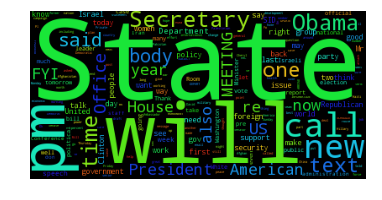

In [14]:
# Display the generated cloud
plt.imshow(wordcloud)
plt.axis("off")

### b. Pre-processed text

To preprocess the text we proceed with these steps ([`clean_entire_corpus`](cleaning.py)):

* Tokenize the corpus and we receive the list of words to further procedure.
* Remove meaningless, short tokens and we put the rest of them into lowercase.
* Get rid of a list of stowords extended by the common words we found in the cloud above (to extend the list of meaningless words we go through the list of the firs words cloud)
* We considered using stemming techniques but we abandoned this idea while it couldn't give us more descriptive view of the email content. Also we find not stemmed words easier to proceed.

In [15]:
# Get the list to extend the stopwords list
extra = [line.rstrip('\n').strip() for line in open('extra_stopwords.txt')]

Thus, we preprocess the code.

In [16]:
# Obtain the corpus
corpus = clean_entire_corpus(unique_corpus, 3, extra)

And we proceed generating the cloud of words.

(-0.5, 399.5, 199.5, -0.5)

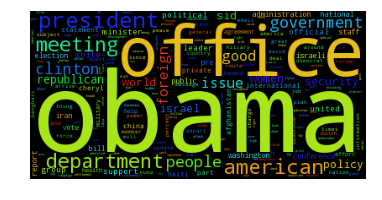

In [17]:
plt.imshow(WordCloud().generate(corpus))
plt.axis("off")

Comparing the two clouds we clearly see how different they are in terms of *"key words"*. The raw corpus contains a lot of meaningless words that occur often in the emails (just because element of the grammar or standard part of a body email), it leads to the lack of information in the cloud. Beside, the second cloud, thanks to the cleaning, seems to be more capable of describing the email contents.

## 2. Country mentions and sentiment analysis

In this task our goal is to:
* Find all the mentions of world countries in the whole corpus.
* Perform sentiment analysis on every email message.

To find all the mentions of countries we need to clean again the data, the procedure we use is different. Hence, we use another function that also extends the list of words that we don't want the body emails to contain. In particulr what we observed is the precence of ISO2 code to identify a country that corresponds to a very common token in the email like `re` which means `response` but is also identified as a country `Réunion`. The same thing happens for some ISO3 code: `ago` used in english as time expression, if we refer to country represents the `Angola`. The list of words that can be misleading in these terms are stored in the file [`extended_country`](extended_country.txt).

In [18]:
# Words to exclude
stop_words = set(stopwords.words('english') + extra)
# Words to exclude for the explained reason related to the countries
extension = [line.rstrip('\n').strip() for line in open('extended_country.txt')]

We create a new column with the processed text expressed as list of words.

In [20]:
# Define the elements of the new column
new_col = []
for i in emails.index:
     new_col += [clean_body_country(emails.loc[i, 'ExtractedBodyText'], stop_words, extension, 2)]
# Create the column
emails['ExtractedBodyText_2'] = new_col 

Thus, we define a set of all the possible countries (expressed in different ways) and a dictionary of the form

                {'name_country' : ['ISO2', 'ISO3', 'Other_way_1', .., 'Other_way_n']}
            
that will be used to check whether a word is or not a country. The `'Other_way_k'` have been added manually.

In [21]:
# Get the list of countries
list_country = list(pycountry.countries)

# Define the country dictionary and the country set
country_dictionary, country_set = country_names(list_country)

Therefore, we count in how many emails each country is mentioned. The function is stored [here](cleaning.py).

In [22]:
# Compute the mentions
mentions_dictionary = country_mentions(country_dictionary, country_set, emails)

We decide to represent the country that have been mentioned in more than 30 mails.

In [37]:
# Keep countries with mentions greater than 30
dict_big_mentions = {}
for c in list(mentions_dictionary.keys()):
    if mentions_dictionary[c] > 30:
        dict_big_mentions[c] = mentions_dictionary[c]

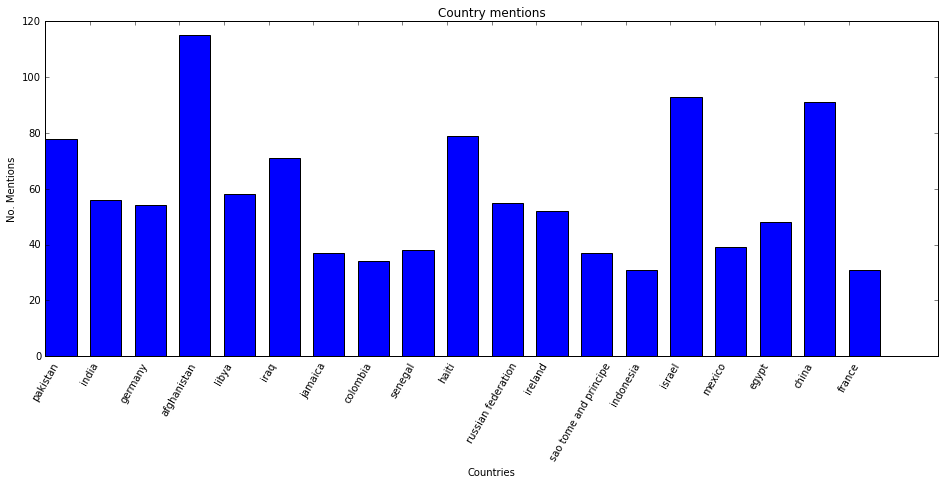

In [39]:
# Plot mentions
plot_mentions(dict_big_mentions)

On the whole, the country that are most mentioned don't sound incorrect. We see that Afganistan, China, Israel and Iran are the ones mentiones in the highest number of mails. It means that the country detection is not so bad, it should be made better in order to avoid counting as country words that are not.

In [ ]:
#for text in emails['ExtractedBodyText']:
#    analyzer = SentimentIntensityAnalyzer()
#    c = analyzer.polarity_scores(text)
 #   print (c)

In [ ]:
#a

In [ ]:
#analyzer = SentimentIntensityAnalyzer()

In [ ]:
#analyzer.polarity_scores(a)

## 3.

## 4. *BONUS*